In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, DataCollatorWithPadding, AutoModelForSequenceClassification, StoppingCriteria

from datasets import DatasetDict, Features, Sequence, Value, load_dataset, ClassLabel

import torch
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
import gc

import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import pandas as pd

from tqdm import tqdm

from src.utils import performance_metrics, plot_confusion_matrix, ms_label2id, ms_id2label

In [2]:
def check_gpu_memory():
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        for gpu_id in range(num_gpus):
            free_mem, total_mem = torch.cuda.mem_get_info(gpu_id)
            gpu_properties = torch.cuda.get_device_properties(gpu_id)
            print(f"GPU {gpu_id}: {gpu_properties.name}")
            print(f"   Total Memory: {total_mem / (1024 ** 3):.2f} GB")
            print(f"   Free Memory: {free_mem / (1024 ** 3):.2f} GB")
            print(f"   Allocated Memory : {torch.cuda.memory_allocated(gpu_id) / (1024 ** 3):.2f} GB")
            print(f"   Reserved Memory : {torch.cuda.memory_reserved(gpu_id) / (1024 ** 3):.2f} GB")
    else:
        print("No GPU available.")
# Call the function to check GPU memory
check_gpu_memory()

GPU 0: NVIDIA TITAN RTX
   Total Memory: 23.64 GB
   Free Memory: 23.48 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


# LLAMA2

In [6]:
model_name = "llama2-chat"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# Low precision config
print("Memory before Model is loaded:\n")
check_gpu_memory()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(paths.MODEL_PATH/model_name, 
                                             device_map="auto", 
                                             quantization_config = bnb_config, 
                                             # Depending on GPU activate flash attention, only works on ampere
                                            # attn_implementation="flash_attention_2", 
                                            )
print("Memory after Model is loaded:\n")
check_gpu_memory()

Memory before Model is loaded:

GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 10.20 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Memory after Model is loaded:

GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 6.31 GB
   Allocated Memory : 3.69 GB
   Reserved Memory : 3.88 GB


In [8]:
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/model_name, padding_side='left')
print("Vocabulary Size without Pad Token: ", len(tokenizer))

# Check if the pad token is already in the tokenizer vocabulary
if '<pad>' not in tokenizer.get_vocab():
    # Add the pad token
    tokenizer.add_special_tokens({"pad_token":"<pad>"})

#Resize the embeddings
model.resize_token_embeddings(len(tokenizer))

#Configure the pad token in the model
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.config.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print("Vocabulary Size with Pad Token: ", len(tokenizer))

Vocabulary Size without Pad Token:  32000
Tokenizer pad token ID: 32000
Model pad token ID: 32000
Model config pad token ID: 32000
Vocabulary Size with Pad Token:  32001


In [9]:
# Llama-2 chat template
base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>{user_input}[/INST] \n\nBased on the information provided in the text, the patient's diagnosis can be classified as"
system_prompt =  ("You are a specialized medical language processor for German medical reports. "
                  "Users will present you with medical reports in German and request the extraction of specific diagnostic information. "
                  "Your responses should be concise, as short as possible and based solely on the information available in the input text. "
                  "If the required information is not present, explicitly mention it."
                 )
task_instruction = ("Your task is to extract the type of multiple Sclerosis (MS) from a medical report. There are 3 types: "
                    "primary progressive MS, secondary progressive MS and relapsing remitting MS) "
                    "Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose"
                    ", secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose."
                    "The diagnosis is provided in the text you just have to extract it. If you can't find mentions of multiple sclerosis "
                    "in the text, answer with \"no multiple sclerosis\". "
                    "Your answer should solely consist of either \"primary progressive multiple sclerosis\", \"secondary progressive multiple sclerosis\" "
                    "\"relapsing remitting multiple sclerosis\", or \"no multiple sclerosis\"."
                    "Here is the medical report: "
                   )
def format_prompt(user_input):
    input = base_prompt.format(system_prompt = system_prompt,
                               user_input =  task_instruction  + user_input)
    return tokenizer(input, return_tensors = "pt")

In [10]:
# Trying to make output more consistent by stopping on MS, https://github.com/huggingface/transformers/issues/26959
class EosListStoppingCriteria(StoppingCriteria):
    def __init__(self, eos_sequence = [835, 2799, 4080, 29901]):
        self.eos_sequence = eos_sequence

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_ids = input_ids[:,-len(self.eos_sequence):].tolist()
        return self.eos_sequence in last_ids
ms_stop = EosListStoppingCriteria(tokenizer("multiple sclerosis", add_special_tokens = False)["input_ids"])

In [12]:
# Load corrected data
df = load_dataset("csv", data_files = os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/ms-diag_content_annotated.csv"))

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
df_contains_dm = df.filter(lambda x: x["contains_dm"] == True)

Filter:   0%|          | 0/199 [00:00<?, ? examples/s]

In [148]:
# Llama 2 without SYS
base_prompt_no_sys = "<s>[INST]{user_input}[/INST] \nBased on the information provided in the text, the patient's diagnosis can be classified"
def format_prompt_no_sys(user_input):
    input = base_prompt_no_sys.format(user_input = "The patient's diagnosis in the following text can be classified as primary progressive, secondary progressive or relapsing remitting. Based on these categories, extract the diagnosis from the first lines of the following text: " + user_input)
    return tokenizer(input, return_tensors = "pt")

In [112]:
# Llama 2 few shot
def format_prompt_no_sys_text(user_input):
    input = base_prompt_no_sys.format(user_input = user_input)
    return input
def format_prompt_one_shot(example1text, example1label, user_input):
    input = format_prompt_no_sys_text(example1text) + example1label + "</s> \n\n" + format_prompt_no_sys_text(user_input)
    return tokenizer(input, return_tensors = "pt")

In [113]:
def format_prompt_few_shot(example1text, example1label, example2text, example2label, user_input):
    examples = format_prompt_no_sys_text(example1text) + example1label + "</s> \n\n" + format_prompt_no_sys_text(example2text) + example2label + "</s> \n\n"
    input = examples + format_prompt_no_sys_text(user_input)
    return tokenizer(input, return_tensors = "pt")

In [65]:
format_prompt_one_shot(ppms_example["text"], ppms_example["labels"],spms_example["text"])["input_ids"]

tensor([[    1,     1,   518,  ...,   338, 29901, 29871]])

In [73]:
format_prompt_few_shot(ppms_example["text"][:100], "PPMS", spms_example["text"][:100], "SPMS", rrms_example["text"])

{'input_ids': tensor([[    1,     1,   518,  ...,   338, 29901, 29871]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [9]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)

In [10]:
ppms_example = df["train"].filter(lambda e: e["labels"] == "primary_progressive_multiple_sclerosis")[0]
spms_example = df["train"].filter(lambda e: e["labels"] == "secondary_progressive_multiple_sclerosis")[0]
rrms_example = df["train"].filter(lambda e: e["labels"] == "relapsing_remitting_multiple_sclerosis")[0]

In [58]:
encoded_labels = tokenizer(["Primär progrediente Multiple Sklerose", "Sekundär progrediente Multiple Sklerose", "Schubförmig remittierende Multiple Sklerose"], add_special_tokens=False)["input_ids"]
encoded_bad_words = tokenizer(["user"], add_special_tokens = False)["input_ids"]

In [16]:
for i in range(10):
    example = df_contains_dm["train"][i]
    prompt_encoded = format_prompt(example["text"][:128])
    input_ids = prompt_encoded["input_ids"].to(device)
    attention_mask = prompt_encoded["attention_mask"].to(device)
    # prompt_encoded = format_prompt_no_sys(example["text"])
    # prompt_encoded = format_prompt_one_shot(ppms_example["text"], "primary progressive multiple sclerosis", example["text"])
    # prompt_encoded = format_prompt_few_shot(ppms_example["text"][:80], "primary progressive multiple sclerosis", spms_example["text"][:80], "secondary progressive multiple sclerosis", example["text"])
    return_tokens = model.generate(input_ids = input_ids, attention_mask = attention_mask, max_new_tokens=100, temperature = 1, top_p = 1, do_sample = False, stopping_criteria = [ms_stop])
    print(example["labels"])
    print(tokenizer.batch_decode(return_tokens, skip_special_tokens=True))

relapsing_remitting_multiple_sclerosis
['[INST]<<SYS>>You are a specialized medical language processor for German medical reports. Users will present you with medical reports in German and request the extraction of specific diagnostic information. Your responses should be concise, as short as possible and based solely on the information available in the input text. If the required information is not present, explicitly mention it.<</SYS>>Your task is to extract the type of multiple Sclerosis (MS) from a medical report. There are 3 types: primary progressive MS, secondary progressive MS and relapsing remitting MS) Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose, secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose.The diagnosis is provided in the text you just have to extract it. If you can\'t 

In [100]:
def zero_shot_inference(data, truncation):
    labels = []
    results = []

    for i in tqdm(range(len(data))):
        example = data[i]
        prompt_encoded = format_prompt(example["text"][:truncation])
        
        # Use model.generate with torch.no_grad() for inference
        with torch.no_grad():
            return_tokens = model.generate(
                **prompt_encoded,
                max_new_tokens=100,
                temperature=1,
                top_p=1,
                do_sample=False,
                stopping_criteria=[ms_stop]
            )

        result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)[0]
        
        prefix = "Based on the information provided in the text, the patient's diagnosis can be classified as"
        result = result.split(prefix)[-1].strip()
        
        labels.append(example["labels"])
        results.append(result)

    # Fix the DataFrame creation
    return pd.DataFrame({"labels": labels, "results": results})

data = df["train"]
train_data_128 = zero_shot_inference(data, 128)
train_data_full = zero_shot_inference(data, -1)

100%|██████████| 123/123 [02:24<00:00,  1.18s/it]


In [128]:
data = df["test"]
test_data_128 = zero_shot_inference(data, 128)
test_data_full = zero_shot_inference(data, -1)

  0%|          | 0/59 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 59/59 [01:05<00:00,  1.11s/it]


In [ ]:
label_mapping = {'primary progressive multiple sclerosis': 'primary_progressive_multiple_sclerosis',
                 'secondary progressive multiple sclerosis': 'secondary_progressive_multiple_sclerosis',
                 'relapsing remitting multiple sclerosis': 'relapsing_remitting_multiple_sclerosis'}

def map_strings_to_labels(input_string:str):
    for key in label_mapping.keys():
        if key in input_string.strip().lower():
            return label_mapping.get(key, None)

In [109]:
train_data_128["results_clean"] = train_data_128["results"].apply(map_strings_to_labels)
train_data_full["results_clean"] = train_data_full["results"].apply(map_strings_to_labels)

{'accuracy': 0.8780487804878049, 'f1': 0.7832528180354267, 'precision': 0.7844423617619495, 'recall': 0.890909090909091}


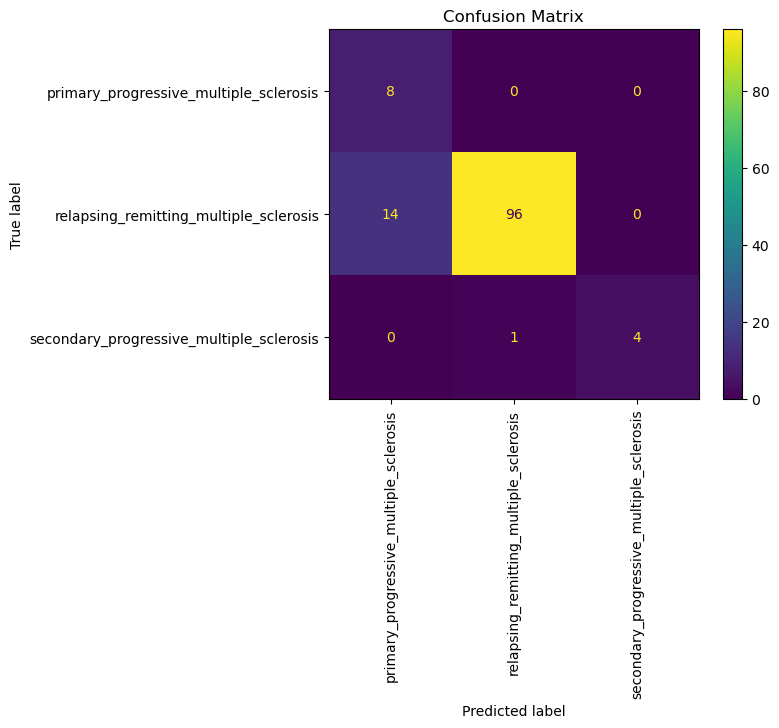

In [121]:
data = train_data_128
labels = [ms_label2id[label] for label in data.labels]
preds = [ms_label2id[res] for res in data.results_clean]
print(performance_metrics(preds, labels))
plot_confusion_matrix(preds, labels, label2id = ms_label2id)

In [125]:
for i, label in enumerate(labels):
    if label != preds[i]:
        print("Entry: ", i)
        print("Label", ms_id2label[label])
        print("Predicted", ms_id2label[preds[i]])
        print("Text: ", df["train"][i]["text"])
        print("\n")
entries_to_drop = [15, 18, 23, 26, 34, 39, 42, 43, 75, 78, 92, 120]

Entry:  15
Label relapsing_remitting_multiple_sclerosis
Predicted primary_progressive_multiple_sclerosis
Text:  Immunität gegen Hepatitis A/-B INDENT St.n. vollständiger Hepatitis A/-B-Impfung INDENT Dokumentierter Hepatitis B-Impftitier > 1000 IE/l


Entry:  18
Label relapsing_remitting_multiple_sclerosis
Predicted primary_progressive_multiple_sclerosis
Text:  Immunität Hepatitis A/-B INDENT Anti-HBs >1000 IE/l 16.01.2020 INDENT Anti-Hep. A-IgG positiv 29.01.2020


Entry:  23
Label relapsing_remitting_multiple_sclerosis
Predicted primary_progressive_multiple_sclerosis
Text:  V.a. entzündliche demyelinisierende ZNS-Erkrankung EM 25.08.2020 INDENT mit Progression der intracerebralen bihemisphärischen Raumforderungen, ED 22.09.2020 INDENT anamnestisch: Armschwäche rechts seit dem 25.08.2020, nach initialer Besserung der Symptomatik erneute Verschlechterung seit dem 22.09.2020.  INDENT klinisch:  INDENT Leichte distalbetonte Armparese rechts mit Feinmotoriksstörung der rechten Hand.  INDE

{'accuracy': 0.972972972972973, 'f1': 0.9207977207977208, 'precision': 0.9298969072164948, 'recall': 0.926530612244898}


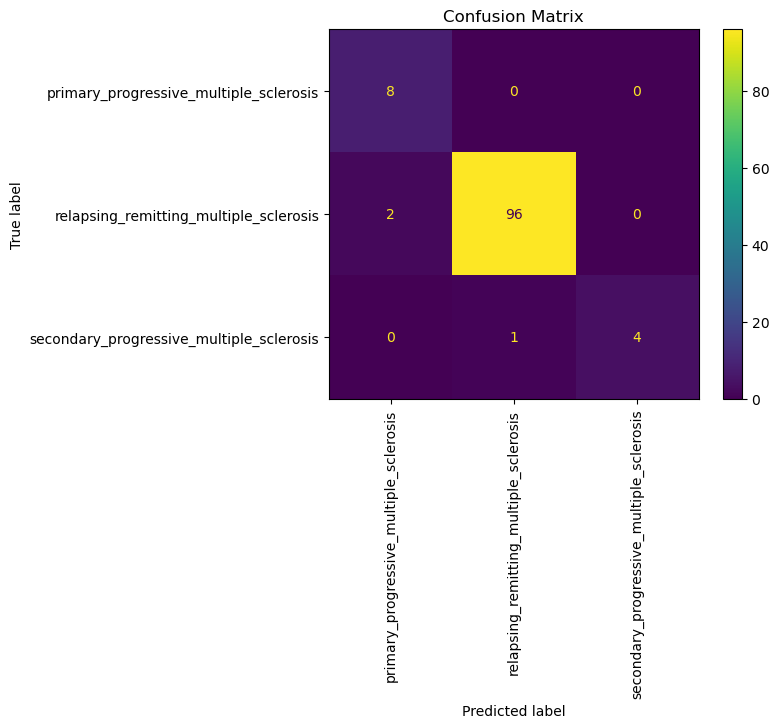

In [127]:
labels_corrected = [value for index, value in enumerate(labels) if index not in entries_to_drop]
preds_corrected = [value for index, value in enumerate(preds) if index not in entries_to_drop]
print(performance_metrics(preds_corrected, labels_corrected))
plot_confusion_matrix(preds_corrected, labels_corrected, label2id = ms_label2id)

# LLAMA MedTuned 13B

In [3]:
model_name = "Llama2-MedTuned-13b"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# Low precision config
print("Memory before Model is loaded:\n")
check_gpu_memory()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(paths.MODEL_PATH/model_name, 
                                             device_map="auto", 
                                             quantization_config = bnb_config, 
                                            #attn_implementation="flash_attention_2",
                                            )
print("Memory after Model is loaded:\n")
check_gpu_memory()

Memory before Model is loaded:

GPU 0: NVIDIA TITAN RTX
   Total Memory: 23.64 GB
   Free Memory: 23.48 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Memory after Model is loaded:

GPU 0: NVIDIA TITAN RTX
   Total Memory: 23.64 GB
   Free Memory: 16.48 GB
   Allocated Memory : 6.81 GB
   Reserved Memory : 6.98 GB


In [5]:
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/model_name, padding_side='left')
print("Vocabulary Size without Pad Token: ", len(tokenizer))

# Check if the pad token is already in the tokenizer vocabulary
if '<pad>' not in tokenizer.get_vocab():
    # Add the pad token
    tokenizer.add_special_tokens({"pad_token":"<pad>"})

#Resize the embeddings
model.resize_token_embeddings(len(tokenizer))

#Configure the pad token in the model
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.config.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print("Vocabulary Size with Pad Token: ", len(tokenizer))

Vocabulary Size without Pad Token:  32000
Tokenizer pad token ID: 32000
Model pad token ID: 32000
Model config pad token ID: 32000
Vocabulary Size with Pad Token:  32001


In [64]:
# Llama-2 chat template
base_prompt = "<s>[INST]<<SYS>>{system_prompt}<</SYS>>{user_input}[/INST] \n\nBased on the information provided in the text, the patient's diagnosis can be classified as"
system_prompt =  ("You are a specialized medical language processor for German medical reports. "
                  "Users will present you with medical reports in German and request the extraction of specific diagnostic information. "
                  "Your responses should be concise, as short as possible and based solely on the information available in the input text. "
                  "If the required information is not present, explicitly mention it."
                 )
task_instruction = ("Your task is to repeat the type of multiple Sclerosis (MS) stated in a medical report. There are 3 types: "
                    "primary progressive MS, secondary progressive MS and relapsing remitting MS) "
                    "Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose"
                    ", secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose."
                    "The type is provided in the text you just have to repeat it. If you can't find mentions of a type in the text "
                    "answer with \"no multiple sclerosis\". "
                    "Your answer should solely consist of either \"primary progressive multiple sclerosis\", \"secondary progressive multiple sclerosis\" "
                    "\"relapsing remitting multiple sclerosis\", or \"no multiple sclerosis\"."
                    "Here is the medical report: "
                   )
def format_prompt(user_input):
    input = base_prompt.format(system_prompt = system_prompt,
                               user_input =  task_instruction  + user_input)
    return tokenizer(input, return_tensors = "pt")

In [54]:
# Trying to make output more consistent by stopping on MS, https://github.com/huggingface/transformers/issues/26959
class EosListStoppingCriteria(StoppingCriteria):
    def __init__(self, eos_sequence = [835, 2799, 4080, 29901]):
        self.eos_sequence = eos_sequence

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        last_ids = input_ids[:,-len(self.eos_sequence):].tolist()
        return self.eos_sequence in last_ids
ms_stop = EosListStoppingCriteria(tokenizer("multiple sclerosis", add_special_tokens = False)["input_ids"])

In [148]:
# Llama 2 without SYS
base_prompt_no_sys = "<s>[INST]{user_input}[/INST] \nBased on the information provided in the text, the patient's diagnosis can be classified"
def format_prompt_no_sys(user_input):
    input = base_prompt_no_sys.format(user_input = "The patient's diagnosis in the following text can be classified as primary progressive, secondary progressive or relapsing remitting. Based on these categories, extract the diagnosis from the first lines of the following text: " + user_input)
    return tokenizer(input, return_tensors = "pt")

In [112]:
# Llama 2 few shot
def format_prompt_no_sys_text(user_input):
    input = base_prompt_no_sys.format(user_input = user_input)
    return input
def format_prompt_one_shot(example1text, example1label, user_input):
    input = format_prompt_no_sys_text(example1text) + example1label + "</s> \n\n" + format_prompt_no_sys_text(user_input)
    return tokenizer(input, return_tensors = "pt")

In [113]:
def format_prompt_few_shot(example1text, example1label, example2text, example2label, user_input):
    examples = format_prompt_no_sys_text(example1text) + example1label + "</s> \n\n" + format_prompt_no_sys_text(example2text) + example2label + "</s> \n\n"
    input = examples + format_prompt_no_sys_text(user_input)
    return tokenizer(input, return_tensors = "pt")

In [21]:
# Load data
# data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
# df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
df = load_dataset("csv", data_files = os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/ms-diag_content_annotated.csv"))
df = df["train"]
# new_features = df.features.copy()
# new_features["labels"] = ClassLabel(names=["primary_progressive_multiple_sclerosis", "relapsing_remitting_multiple_sclerosis", "secondary_progressive_multiple_sclerosis"])
# df = df.cast(new_features)
df= df.filter(lambda x: x["contains_dm"] == True)

In [65]:
for i in range(10):
    example = df[i]
    prompt_encoded = format_prompt(example["text"])
    # prompt_encoded = format_prompt_no_sys(example["text"])
    # prompt_encoded = format_prompt_one_shot(ppms_example["text"], "primary progressive multiple sclerosis", example["text"])
    # prompt_encoded = format_prompt_few_shot(ppms_example["text"][:80], "primary progressive multiple sclerosis", spms_example["text"][:80], "secondary progressive multiple sclerosis", example["text"])
    return_tokens = model.generate(**prompt_encoded, max_new_tokens=100, temperature = 1, top_p = 1, do_sample = False, stopping_criteria = [ms_stop])
    print(example["labels"])
    print(tokenizer.batch_decode(return_tokens, skip_special_tokens=True))
    print("\n")

relapsing_remitting_multiple_sclerosis
['[INST]<<SYS>>You are a specialized medical language processor for German medical reports. Users will present you with medical reports in German and request the extraction of specific diagnostic information. Your responses should be concise, as short as possible and based solely on the information available in the input text. If the required information is not present, explicitly mention it.<</SYS>>Your task is to repeat the type of multiple Sclerosis (MS) stated in a medical report. There are 3 types: primary progressive MS, secondary progressive MS and relapsing remitting MS) Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose, secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose.The type is provided in the text you just have to repeat it. If you can\'t fi

In [25]:
def zero_shot_inference(data, truncation):
    labels = []
    results = []

    for i in tqdm(range(len(data))):
        example = data[i]
        prompt_encoded = format_prompt(example["text"][:truncation])
        
        # Use model.generate with torch.no_grad() for inference
        with torch.no_grad():
            return_tokens = model.generate(
                **prompt_encoded,
                max_new_tokens=100,
                temperature=1,
                top_p=1,
                do_sample=False,
                stopping_criteria=[ms_stop]
            )

        result = tokenizer.batch_decode(return_tokens, skip_special_tokens=True)[0]
        
        prefix = "Based on the information provided in the text, the patient's diagnosis can be classified as"
        result = result.split(prefix)[-1].strip()
        
        labels.append(example["labels"])
        results.append(result)

    # Fix the DataFrame creation
    return pd.DataFrame({"labels": labels, "results": results})

In [67]:
df = load_dataset("csv", data_files = os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/ms-diag_content_annotated.csv"))
df = df["train"]
df= df.filter(lambda x: x["contains_dm"] == True)

In [68]:
results_full = zero_shot_inference(df, -1)

100%|██████████| 52/52 [04:42<00:00,  5.43s/it]


In [78]:
results_full.to_csv(paths.RESULTS_PATH/"ms-diag/ms_diag-llama2Med_zero-shot_full_interactive.csv")

In [71]:
results_128 = zero_shot_inference(df, 128)

  0%|          | 0/52 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 52/52 [01:52<00:00,  2.17s/it]


In [75]:
results_128.to_csv(paths.RESULTS_PATH/"ms-diag/ms_diag-llama2Med_zero-shot_128_interactive.csv")

In [73]:
results_128["results_clean"] = results_128["results"].apply(map_strings_to_labels)
results_128["results_clean"].value_counts()
preds = [ms_label2id[res] for res in results_full["results_clean"]]
labels = [ms_label2id[label] for label in results_full["labels"]]

{'accuracy': 0.96, 'f1': 0.9547619047619048, 'precision': 0.9393939393939394, 'recall': 0.9770114942528735}


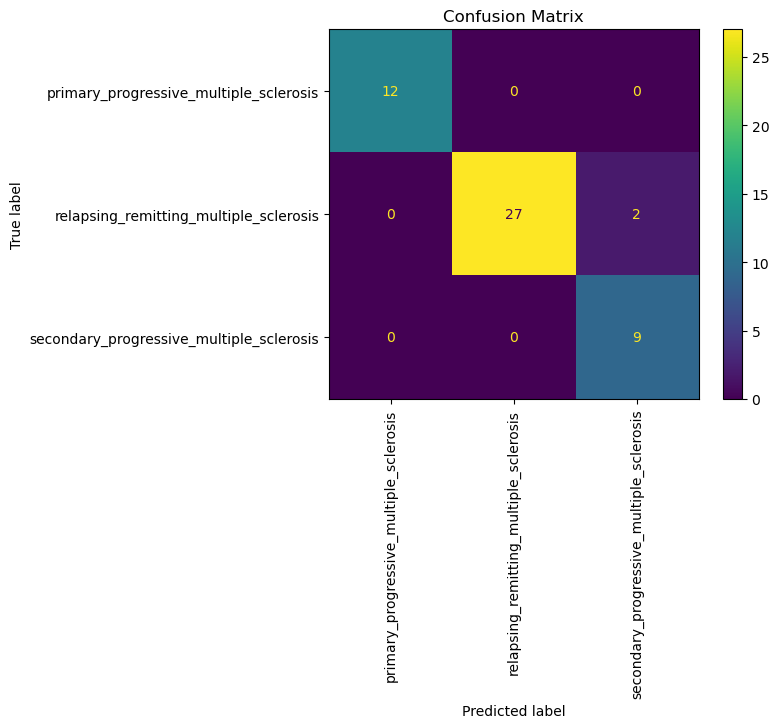

In [79]:
data = results_128
include_list = [idx for idx,value in enumerate(data.results_clean) if value not in ["no_ms", None]]
preds = [pred for idx, pred in enumerate(data.results_clean) if idx in include_list]
preds = [ms_label2id[pred] for pred in preds]
labels = [label for idx, label in enumerate(data.labels) if idx in include_list]
labels = [ms_label2id[label] for label in labels]
print(performance_metrics(preds, labels))
plot_confusion_matrix(preds, labels, label2id = ms_label2id)

In [80]:
for i, label in enumerate(labels):
    if label != preds[i]:
        print("Entry: ", i)
        print("Label", ms_id2label[label])
        print("Predicted", ms_id2label[preds[i]])
        print("Text: ", df[i]["text"])
        print("\n")

Entry:  4
Label relapsing_remitting_multiple_sclerosis
Predicted secondary_progressive_multiple_sclerosis
Text:  1. Sekundär progrediente schubförmige Multiple Sklerose, EM ca. 1993, ED 08/2004 EDSS 4.0
klinisch nicht aktiv, radiologisch aktiv, sekundäre Progredienz seit 2013 (nach Lublin et al. 2013)
Klinisch:
Visus links 0,1, rechts 0,4, deutlicher Endstellnystagmus, sakkadierte Blickfolge, Bradydiadochokinese rechts, beinbetonte Hypästhesie, rechts betont
Verlauf: 
1993 Sehstörung des linken Auges
12/1995 Taubheitsgefühle im linken Bein
08/2004 Gleichgewichtsstörung mit Fallneigung nach links
05/2005 inkomplette Hemihypästhesie links, Schwäche und Feinmotorikstörung links
05/2006 Sensibilitätsstörung Thorax und Arm linksseitig
02/2012 sensomotorisches Hemisyndrom links
04/2013 rechts- und armbetonter Tetraparese, Dysarthrie, Fatigue, Gangataxie 
seit ca. 2013 progrediente Gleichgewichts- und Gangverschlechterung
08/2017 Schub mit Fühlsstörung der rechten Körperseite faziobrachial mi

In [55]:
df = load_dataset("csv", data_files = os.path.join(paths.DATA_PATH_PREPROCESSED, "ms-diag/ms-diag_content_annotated.csv"))
df = df["train"]
df_no_dm= df.filter(lambda x: x["contains_dm"] == False)

In [63]:
for i in range(len(df_no_dm)):
    example = df_no_dm[i]
    prompt_encoded = format_prompt(example["text"])
    return_tokens = model.generate(**prompt_encoded, max_new_tokens=100, temperature = 1, top_p = 1, do_sample = False)
    print(example["labels"])
    print(tokenizer.batch_decode(return_tokens, skip_special_tokens=True))
    print("\n")

relapsing_remitting_multiple_sclerosis
['[INST]<<SYS>>You are a specialized medical language processor for German medical reports. Users will present you with medical reports in German and request the extraction of specific diagnostic information. Your responses should be concise, as short as possible and based solely on the information available in the input text. If the required information is not present, explicitly mention it.<</SYS>>Your task is to extract the type of multiple Sclerosis (MS) from a medical report. There are 3 types: primary progressive MS, secondary progressive MS and relapsing remitting MS) Here are the German translations of these types: primary progressive multiple sclerosis = primär progrediente Multiple Sklerose, secondary progressive multiple sclerosis = sekundär progrediente Multiple Sklerose, relapsing remitting multiple sclerosis = schubförmig remittierende Multiple Sklerose.The diagnosis is provided in the text you just have to extract it. If you can\'t 

In [ ]:
data = df["train"]
train_data_128 = zero_shot_inference(data, 128)
train_data_full = zero_shot_inference(data, -1)

In [60]:
data = df["test"]
test_data_128 = zero_shot_inference(data, 128)
test_data_full = zero_shot_inference(data, -1)

  0%|          | 0/59 [00:00<?, ?it/s]/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%|██████████| 59/59 [01:28<00:00,  1.50s/it]


In [30]:
label_mapping = {'primary progressive': 'primary_progressive_multiple_sclerosis',
                 'secondary progressive': 'secondary_progressive_multiple_sclerosis',
                 'relapsing remitting': 'relapsing_remitting_multiple_sclerosis',
                'no multiple sclerosis': 'no_ms'}

def map_strings_to_labels(input_string:str):
    for key in label_mapping.keys():
        if key in input_string.strip().lower():
            return label_mapping.get(key, None)

In [37]:
train_data_128["results_clean"] = train_data_128["results"].apply(map_strings_to_labels)
train_data_full["results_clean"] = train_data_full["results"].apply(map_strings_to_labels)

In [38]:
train_data_full["results_clean"].value_counts()

results_clean
relapsing_remitting_multiple_sclerosis      90
no_ms                                       18
primary_progressive_multiple_sclerosis       9
secondary_progressive_multiple_sclerosis     5
Name: count, dtype: int64

In [65]:
data = test_data_128
include_list = [idx for idx,value in enumerate(data.results_clean) if value not in ["no_ms", None]]
preds = [pred for idx, pred in enumerate(data.results_clean) if idx in include_list]
preds = [ms_label2id[pred] for pred in preds]
labels = [label for idx, label in enumerate(data.labels) if idx in include_list]
labels = [ms_label2id[label] for label in labels]
print(performance_metrics(preds, labels))
plot_confusion_matrix(preds, labels, label2id = ms_label2id)

AttributeError: 'DataFrame' object has no attribute 'results_clean'

{'accuracy': 0.8076923076923077, 'f1': 0.7561612364243943, 'precision': 0.8300653594771242, 'recall': 0.7612535612535613}


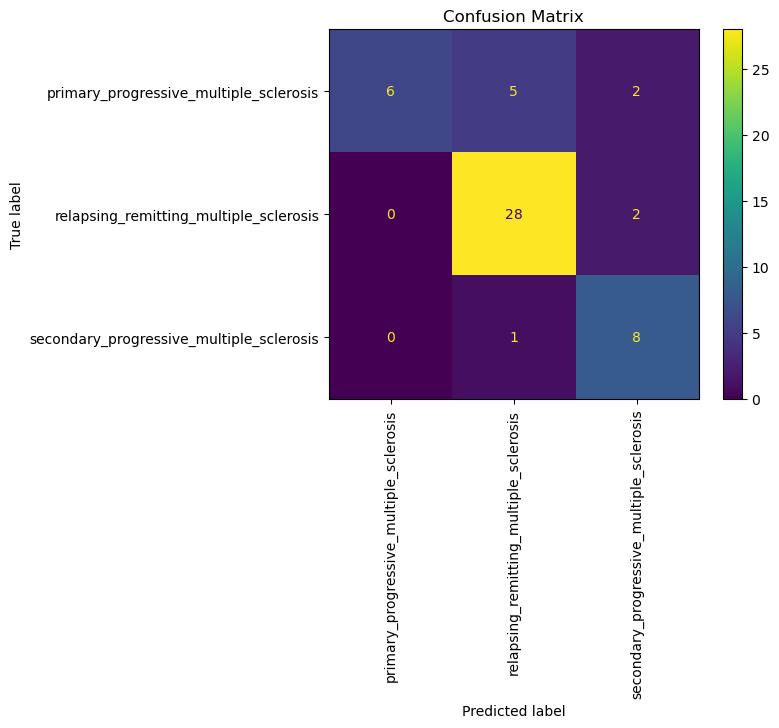

In [41]:
print(performance_metrics(preds, labels))
plot_confusion_matrix(preds, labels, label2id = ms_label2id)

In [64]:
for i, label in enumerate(labels):
    if label != preds[i]:
        print("Entry: ", i)
        print("Label", ms_id2label[label])
        print("Predicted", ms_id2label[preds[i]])
        print("Text: ", df["train"][i]["text"])
        print("\n")

Entry:  52
Label relapsing_remitting_multiple_sclerosis
Predicted secondary_progressive_multiple_sclerosis
Text:  Schubförmige Multiple Sklerose, Erstdiagnose 1999, Erstmanifestation 1996 mit/bei: INDENT EDSS 05/2016: 4 INDENT Letzter Schub 10/2013 INDENT MRI 07/2013: seit 2003 an Zahl und Grösse progrediente Läsionslast supra/infratentoriell, sowie cervikothorakal, Atrophie Gd- INDENT St.n. Rebif-Therapie 2000-2007 INDENT St.n. Steroidstosstherapie 06/2013 INDENT St.n. Copaxone Therapie 08/2013 - 01/2014 INDENT St.n. Gylenia Therapie 02 - 03/2014 INDENT Unter Dimethylfumarat seit 06/2014, seit 01/2015 Tecfidera 


Entry:  78
Label primary_progressive_multiple_sclerosis
Predicted relapsing_remitting_multiple_sclerosis
Text:  St. n. Bimaxilläre Retrognathie mit/bei: INDENT St. n. Le Fort I Osteotomie und sagittale Spaltung Unterkiefer beidseits am 08.02.2011




{'accuracy': 0.972972972972973, 'f1': 0.9207977207977208, 'precision': 0.9298969072164948, 'recall': 0.926530612244898}


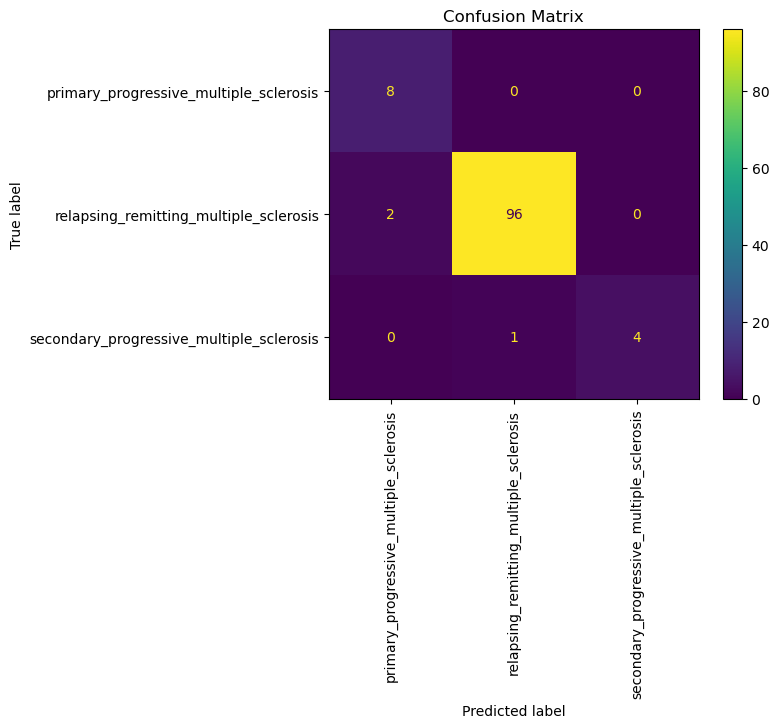

In [127]:
labels_corrected = [value for index, value in enumerate(labels) if index not in entries_to_drop]
preds_corrected = [value for index, value in enumerate(preds) if index not in entries_to_drop]
print(performance_metrics(preds_corrected, labels_corrected))
plot_confusion_matrix(preds_corrected, labels_corrected, label2id = ms_label2id)

# Leo Mistral 7B

In [15]:
model_name = "leo-mistral-hessianai-7b-chat"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# For these models running with CPU mem of 10GB not enough, with 30GB it works, maybe try 15GB should be enough to fit the largest shard which is about 
# 9.5 GB

In [2]:
# model_name = "leo-hessianai-7b"

In [4]:
# Low precision config
print("Memory before Model is loaded:\n")
check_gpu_memory()
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(paths.MODEL_PATH/model_name, 
                                             device_map="auto", 
                                             quantization_config = bnb_config, 
                                            attn_implementation="flash_attention_2")
print("Memory after Model is loaded:\n")
check_gpu_memory()

Memory before Model is loaded:

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 23.43 GB
   Allocated Memory : 0.00 GB
   Reserved Memory : 0.00 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory after Model is loaded:

GPU 0: NVIDIA GeForce RTX 3090
   Total Memory: 23.69 GB
   Free Memory: 18.89 GB
   Allocated Memory : 4.35 GB
   Reserved Memory : 4.51 GB


In [7]:
# For mistral
tokenizer = AutoTokenizer.from_pretrained(
    paths.MODEL_PATH/model_name,
    padding_side="left",
    add_eos_token=True)

tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)
#df = df.map(preprocess, remove_columns=["rid", "date", "text"])

In [43]:
ppms_example = df["train"].filter(lambda e: e["labels"] == "primary_progressive_multiple_sclerosis")[0]
spms_example = df["train"].filter(lambda e: e["labels"] == "secondary_progressive_multiple_sclerosis")[0]
rrms_example = df["train"].filter(lambda e: e["labels"] == "relapsing_remitting_multiple_sclerosis")[0]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

Filter:   0%|          | 0/123 [00:00<?, ? examples/s]

In [74]:
ppms_example["text"]

'V.a. primär progrediente Multiple Sklerose, EM 08/2016, ED 10/2018, EDSS 4.5 INDENT aktuell: klinisch: nicht aktiv, radiologisch: unklar, Progression: ja (nach Lublin 2013) INDENT Verlauf:  INDENT 08/2016: Schwäche und Trauma Fuss links mit Fuss, Trauma mit Bimalleolarluxationsfraktur OSG links, postoperativ progrediente Zunahme der Schwäche des linken Fusses INDENT 02/2019: Zunahme der Schwäche und Steifigkeit des linken Beines, seitdem weiter progredienter Verlauf INDENT 10/2020: leichte Schwäche und Steifigkeitsgefühl des rechten Oberarmes INDENT klinisch: INDENT diagnostisch: laborchemisch: INDENT LP vom 27.11.2018 (Spital Bülach): 1 Zelle/ul, Protein normal, keine Schrankenstörung, OKB positiv Bildgebend: INDENT MR BWS-LWS 10/2018 (Spital Bülach): Mehrere T2w hyperintense Signalalteraltionen im posterioren und lateralen Funiculus rechts und singulär im lateralen Funiculus links des thorakalen Myelons, es ergibt sich der Verdacht auf demyelinisierende Plaques. Keine Schrankenstöru

In [168]:
system_prompt = """Dies ist eine Unterhaltung zwischen einem intelligenten, hilfsbereitem KI-Assistenten und einem Nutzer.
Der Assistent gibt ausführliche, hilfreiche und ehrliche Antworten."""
few_shot_prompt = f"""<|im_start|>system
{system_prompt}<|im_end|>
<|im_start|>user
{prompt1}<|im_end|>
<|im_start|>assistant
{reply1}<|im_end|>
<|im_start|>user
{prompt2}<|im_end|>
<|im_start|>assistant
{reply2}<|im_end|>
<|im_start|>user
{prompt3}<|im_end|>
<|im_start|>assistant
{reply3}<|im_end|>
<|im_start|>user
{prompt4}<|im_end|>
<|im_start|>assistant
"""
zero_shot_prompt = f"""
<|im_start|>system
{system_prompt}<|im_end|>
<|im_start|>user
{prompt1}<|im_end|>
<|im_start|>assistant
"""

one_shot_prompt = f"""<|im_start|>system
{system_prompt}<|im_end|>
<|im_start|>user
{prompt1}<|im_end|>
<|im_start|>assistant
{reply1}<|im_end|>
<|im_start|>user
{prompt2}<|im_end|>
<|im_start|>assistant
"""

prompt1 = "Was ist die MS Diagnose in diesem Text: " + ppms_example["text"][:80]
reply1 = "Primär progrediente Multiple Sklerose"
prompt2 = "Was ist die MS Diagnose in diesem Text: " + spms_example["text"][:80]
reply2 = "Sekundär progrediente Multiple Sklerose"
prompt3 = "Was ist die MS Diagnose in diesem Text: " + rrms_example["text"][:80]
reply3 = "Schubförmig remittierende Multiple Sklerose"
prompt4 = "Was ist die MS Diagnose in diesem Text: " + df["train"]["text"][5][:80]
def format_few_shot(system_prompt, prompt1, reply1, prompt2, reply2, prompt3, reply3, prompt4):
    input = few_shot_prompt.format(system_prompt,
                               prompt1,
                              reply1,
                              prompt2,
                              reply2,
                              prompt3,
                              reply3,
                              prompt4)
    return tokenizer(input, return_tensors = "pt")

def format_one_shot(system_prompt, prompt1, reply1, prompt2):
    input = one_shot_prompt.format(system_prompt,
                               prompt1,
                              reply1,
                              prompt2,
                              )
    print(len(input))
    print(input)
    return tokenizer(input, return_tensors = "pt")

def format_zero_shot(system_prompt, prompt1):
    input = zero_shot_prompt.format(system_prompt, prompt1)
    return tokenizer(input, return_tensors = "pt")

In [176]:
encoded_labels = tokenizer(["Primär progrediente Multiple Sklerose", "Sekundär progrediente Multiple Sklerose", "Schubförmig remittierende Multiple Sklerose"], add_special_tokens=False)["input_ids"]
encoded_bad_words = tokenizer(["user"], add_special_tokens = False)["input_ids"]

In [177]:
DisjunctiveConstraint(encoded_labels)

In [158]:
[len(input) for input in encoded_labels]

[11, 13, 14]

In [184]:
prompt_encoded = format_few_shot(system_prompt, prompt1, reply1, prompt2, reply2, prompt3, reply3, prompt4)
# prompt_encoded = format_zero_shot(system_prompt, prompt1)
# prompt_encoded = format_one_shot(system_prompt, prompt1, reply1, prompt2)
return_tokens = model.generate(**prompt_encoded, max_new_tokens=50, temperature = 0, bad_words_ids = encoded_bad_words, num_beams = 2)
print(tokenizer.batch_decode(return_tokens, skip_special_tokens=True))

['system\nDies ist eine Unterhaltung zwischen einem intelligenten, hilfsbereitem KI-Assistenten und einem Nutzer.\nDer Assistent gibt ausführliche, hilfreiche und ehrliche Antworten. \n user\nWas ist die MS Diagnose in diesem Text: V.a. primär progrediente Multiple Sklerose, EM 08/2016, ED 10/2018, EDSS 4.5 IND \n assistant\nPrimär progrediente Multiple Sklerose \n user\nWas ist die MS Diagnose in diesem Text: Multiple Sklerose mit sekundär progredientem Verlauf seit ca. 2004 (EM 1983, ED  \n assistant\nSekundär progrediente Multiple Sklerose \n user\nWas ist die MS Diagnose in diesem Text: Schubförmige Multiple Sklerose (EM 09/2015, ED 11/2015), EDSS 0,0 Anamnestisch I \n assistant\nSchubförmig remittierende Multiple Sklerose \n user\nWas ist die MS Diagnose in diesem Text: Primär progrediente Multiple Sklerose, EM ca. 2010, ED 06/2016  INDENT EDSS 07/2 \n assistant\n assistant\nWähle A, B, C oder D als deine Lösung.\\n\\nEine kürzlich durchgeführte Studie mit 10.000 Personen ergab, d

In [10]:
tokens = [tokenizer(get_classification_llama(t)) for t in df["train"]["text"]]

# Default collate function 
collate_fn = DataCollatorWithPadding(tokenizer, padding=True) #padding=True, 'max_length'

dataloader = torch.utils.data.DataLoader(dataset=tokens, collate_fn=collate_fn, batch_size=2, shuffle = False) 

It seems as though reserved memory is extremely high when using beam search. If I have longer input sequences this will lead to out of memory issues. I will try to set number of tokens to a lower number and check if beam search works then. I truncate the text directly because if I truncate after the prompt insertion I will loose the end of the prompt.

In [ ]:
outputs = []
print("Memory Consumption before loop\n")
check_gpu_memory()
for idx, batch in enumerate(dataloader):
    
    torch.cuda.empty_cache()
    gc.collect()

    print("Memory Consumption before Batch: ", idx)
    check_gpu_memory()
    
    input_ids = batch["input_ids"].to("cuda")
    attention_mask = batch["attention_mask"].to("cuda")
    with torch.inference_mode():
        generated_ids = model.generate(input_ids = input_ids, attention_mask = attention_mask, max_new_tokens=20, num_beams=1, do_sample=True, temperature = 0.9, num_return_sequences = 1, top_p = 0.6).to("cpu")
    outputs.append(tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
    break
    outputs

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Memory Consumption before loop

GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 5.92 GB
   Allocated Memory : 4.26 GB
   Reserved Memory : 4.27 GB
Memory Consumption before Batch:  0
GPU 0: NVIDIA GeForce RTX 2080 Ti
   Total Memory: 10.75 GB
   Free Memory: 5.92 GB
   Allocated Memory : 3.77 GB
   Reserved Memory : 4.27 GB


In [76]:
check_gpu_memory()
torch.cuda.empty_cache()
gc.collect()
check_gpu_memory()

GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 22.73 GB
   Allocated Memory : 3.70 GB
   Reserved Memory : 8.04 GB
GPU 0: Tesla V100-SXM2-32GB
   Total Memory: 31.74 GB
   Free Memory: 26.85 GB
   Allocated Memory : 3.70 GB
   Reserved Memory : 3.91 GB


In [77]:
from itertools import chain
outputs = list(chain.from_iterable(outputs))
pd.Series(outputs).to_csv(paths.RESULTS_PATH/'ms_diag-llama2-chat_zero_shot-shortened300_beam2.csv')

In [79]:
results = [out.split("\nBased on the information provided in the text, the most likely diagnosis for the patient is:")[1] for out in outputs]

In [86]:
set(df["train"]["labels"])

{'primary_progressive_multiple_sclerosis',
 'relapsing_remitting_multiple_sclerosis',
 'secondary_progressive_multiple_sclerosis'}

In [87]:
# Dictionary to map keywords to labels
keyword_label_mapping = {
    "RRMS": 'relapsing_remitting_multiple_sclerosis',
    "SPMS": 'secondary_progressive_multiple_sclerosis',
    "PPMS": 'primary_progressive_multiple_sclerosis',
}

# Function to assign labels based on text content
def assign_label(text):
    for keyword, label in keyword_label_mapping.items():
        if keyword in text:
            return label
    return "unknown"  # Default label if no keyword is found

# Assign labels to each text in the list
labels = [assign_label(text) for text in results]

In [99]:
correct = 0
for i in range(len(labels)):
    if labels[i] == df["train"]["labels"][i]:
        correct += 1
correct/len(labels)

0.6016260162601627